# Training of models

In this notebook, each model explored will be trained and a quick visualization from samples will be shown. Moreover, the location of the input points on the learnt manifold will be represented using the Euclidean chart

## Simple VAE Training

Using device: cpu


100%|██████████| 50/50 [03:58<00:00,  4.77s/it]


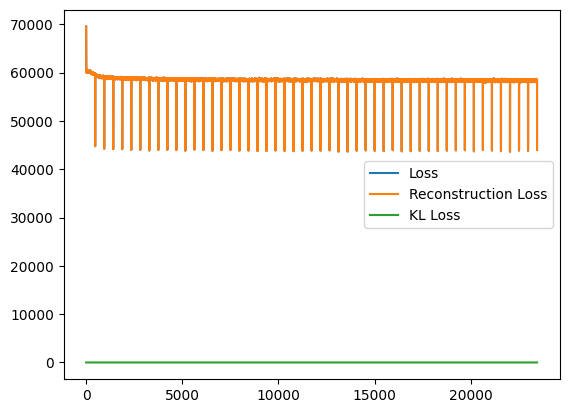

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Using device: {device}")

from utils.train import train_model
from utils.training_params import TrainingParameters
from models.vae import VariationalAutoencoder

train_params = TrainingParameters(
    learning_rate = 1e-2,
    batch_size = 128,
    num_epochs = 50,
)
hidden_dim = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)
vae = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)

train_model(vae, trainloader, train_params, device, save=True)

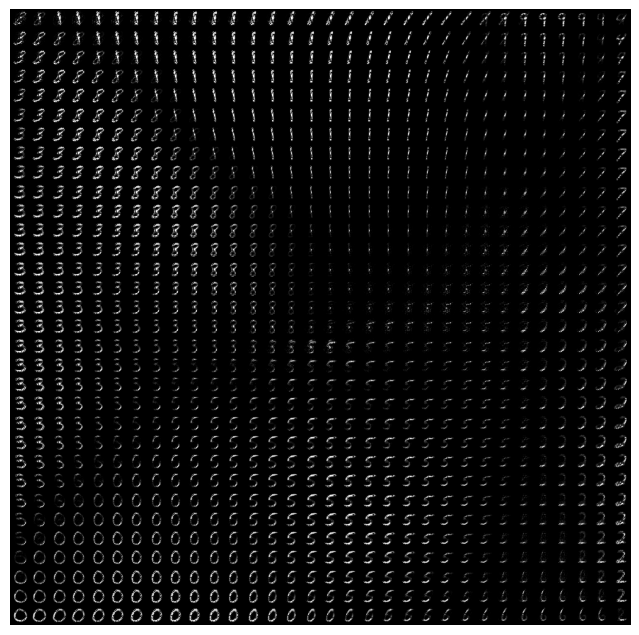

In [14]:
from utils.visualize import visualize_latent_grid

visualize_latent_grid(vae, device, 32)

# Isometric Representation

Using device: cpu


100%|██████████| 20/20 [03:15<00:00,  9.79s/it]


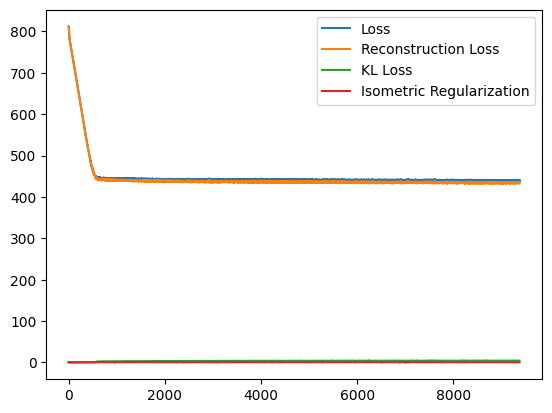

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import tqdm
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Using device: {device}")

from utils.training_params import TrainingParameters
from utils.train import train_model
from models.irvae import IRVAE

irvae = IRVAE([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28]).to(device)

train_params = TrainingParameters(
    learning_rate = 1e-3,
    batch_size = 128,
    num_epochs = 20,
)

hidden_dim = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)
train_model(irvae, trainloader, train_params, device, save=True)

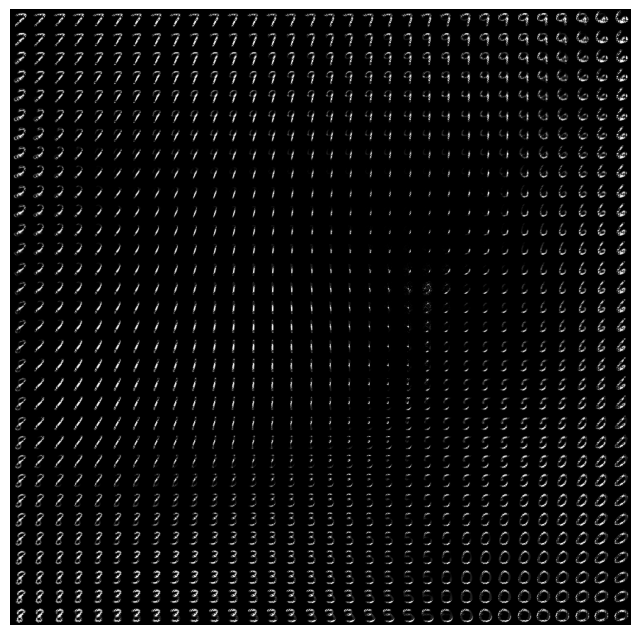

In [3]:
from utils.visualize import visualize_latent_grid

visualize_latent_grid(irvae, device, 32)

## RBF VAE

In [12]:
import os

import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import trange

from utils.training_params import TrainingParameters
from models.vae import VariationalAutoencoder

device = torch.device("cpu")

if not os.path.exists("./pretrained_models/vae.pth"):
    raise KeyError("You need to run the training notebook first.")


hidden_dim = 2
model = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)
model.load_state_dict(torch.load("./pretrained_models/vae.pth", map_location=device, weights_only=True))


transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

train_params = TrainingParameters(
    learning_rate = 1e-4,
    batch_size = 128,
    num_epochs = 40,
)

hidden_dim = 2
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)

In [13]:
z_train = []
y_train = []

model.eval()
with torch.no_grad():
    for x, _ in trainloader:
        _, z, _, _ = model(x)
        
        z_train.append(z.cpu())
        y_train.append(x.cpu())

z_train = torch.cat(z_train, dim=0)
y_train = torch.cat(y_train, dim=0)

z_trainset = torch.utils.data.TensorDataset(z_train, y_train)
z_trainloader = torch.utils.data.DataLoader(z_trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)

In [14]:
from models.rbf import RBFNet

num_clusters = 16
a = 0.85

z_train_np = z_train

rbf = RBFNet(z_train_np, output_dim=28*28, K=num_clusters, a=a)

100%|██████████| 40/40 [01:28<00:00,  2.20s/it]


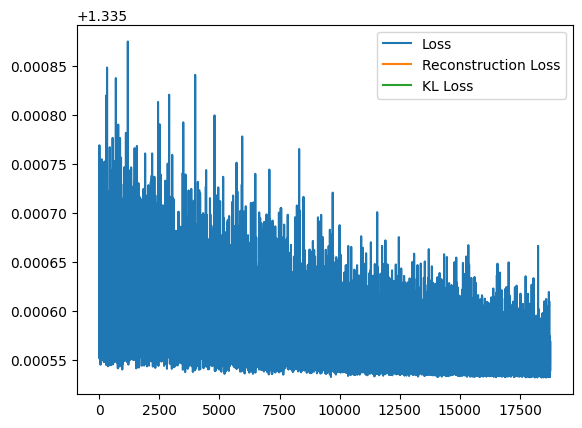

In [15]:
# TODO: Change the code below to train the RBF on encoded x_train dataset:

import matplotlib.pyplot as plt

optimizer = torch.optim.AdamW(rbf.parameters(), lr=train_params.learning_rate)
loss_legend = model.loss_legend()
total_losses = [[] for _ in range(len(loss_legend))]

eps = 1e-8
lambda_reg = 1e-5

model.eval()
for epoch in trange(train_params.num_epochs):
    for z, y in z_trainloader:
        z = z.to(device)
        with torch.no_grad():
            y_hat = model.decoder(z).reshape_as(y)
        y_residual = (y-y_hat)**2 + eps
        y_residual = y_residual.clamp_max(1e6)
        new_y = 1 / y_residual # This is the inverse variance mentioned in the paper.

        losses = [rbf.loss(z, new_y)]
        total_loss = losses[0]

        # L2 regularization as recommended by the oddity paper
        # TODO: move l2 reg into model?
        l2_norm = sum(p.pow(2).sum() for p in model.parameters())
        total_loss += lambda_reg * l2_norm
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        for i, loss in enumerate(losses):
            total_losses[i].append(loss.item())
        
        # This code should be altered to clamp the W weights to be positive.
        rbf.W.weight.data.clamp_(min=0)


for loss in total_losses:
    plt.plot(loss)
plt.legend(loss_legend)
plt.show()

torch.save(model.state_dict(), f"./pretrained_models/{model.short_name()}.pth")



In [10]:
print(rbf.bandwidths)

Parameter containing:
tensor([58.8132,  4.7885,  8.5916,  3.8749, 40.1934, 25.9875,  2.5776, 29.2331,
         4.2113, 26.2987, 16.1250, 10.5822, 17.6821, 26.5965,  2.2362, 12.7141])


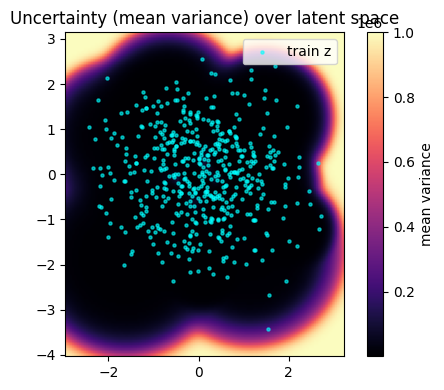

Uncertainty stats (mean variance over outputs):
  min:  178.1709
  max:  1000000.0000
  mean: 177011.4062
  std:  312531.6875


In [11]:
# Visualization code from ChatGPT


import torch
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------
# assume you have this already:
#   rbf_net: RBFNet(z_train, output_dim, K, a)
#   and that it outputs beta(z): [B, D]
# -------------------------------------------------------

def visualize_uncertainty(rbf_net, z_train, dim0=0, dim1=1, grid_points=100, device="cpu"):
    """
    Visualize uncertainty (variance = 1/beta) over a 2D slice of latent space.

    rbf_net: trained RBFNet
    z_train: [N, z_dim] tensor of encoded train latents (used to set plot range)
    dim0, dim1: which latent dims to plot
    """
    rbf_net.eval()
    rbf_net.to(device)

    z_train = z_train.detach().cpu()
    z_min = z_train[:, [dim0, dim1]].min(dim=0).values
    z_max = z_train[:, [dim0, dim1]].max(dim=0).values

    # add a little padding
    pad = 0.1 * (z_max - z_min)
    z_min = z_min - pad
    z_max = z_max + pad

    # build grid
    x_lin = torch.linspace(z_min[0].item(), z_max[0].item(), grid_points)
    y_lin = torch.linspace(z_min[1].item(), z_max[1].item(), grid_points)
    X, Y = torch.meshgrid(x_lin, y_lin, indexing="ij")  # [G,G]

    # flatten to (G*G, 2) and pad to full latent dim if needed
    z_dim = z_train.shape[1]
    Z = torch.zeros(grid_points * grid_points, z_dim)
    Z[:, dim0] = X.reshape(-1)
    Z[:, dim1] = Y.reshape(-1)

    Z = Z.to(device)
    with torch.no_grad():
        beta = rbf_net(Z)               # [G*G, D]
        # turn precision into variance
        var = 1.0 / beta                # [G*G, D]
        # aggregate over output dims: mean variance
        var_mean = var.mean(dim=1)      # [G*G]

    var_img = var_mean.reshape(grid_points, grid_points).cpu().numpy()

    # -------------------------------------------------------
    # Plot heatmap
    # -------------------------------------------------------
    plt.figure(figsize=(5, 4))
    plt.title("Uncertainty (mean variance) over latent space")
    # imshow uses (row, col) = (y, x), so we transpose / flip as needed
    plt.imshow(
        var_img.T,
        origin="lower",
        extent=[z_min[0].item(), z_max[0].item(), z_min[1].item(), z_max[1].item()],
        cmap="magma"
    )
    plt.colorbar(label="mean variance")
    # overlay training latents
    plt.scatter(
        z_train[:, dim0].numpy(),
        z_train[:, dim1].numpy(),
        s=5,
        c="cyan",
        alpha=0.6,
        label="train z"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------------------------------------------------------
    # Print some simple stats
    # -------------------------------------------------------
    print("Uncertainty stats (mean variance over outputs):")
    print(f"  min:  {var_mean.min().item():.4f}")
    print(f"  max:  {var_mean.max().item():.4f}")
    print(f"  mean: {var_mean.mean().item():.4f}")
    print(f"  std:  {var_mean.std().item():.4f}")


# -------------------------------------------------------
# Example usage
# -------------------------------------------------------
if __name__ == "__main__":
    # suppose you already have:
    #  - z_train: [N, z_dim] from your VAE encoder
    #  - rbf_net: trained instance

    # fake example to illustrate shape:
    z_dim = 2
    N = 500
    z_train = torch.randn(N, z_dim)

    # you would load / create your real rbf_net here
    # from your previous code, something like:
    # rbf_net = RBFNet(z_train, output_dim=784, K=50, a=1.0)

    # here we'll just fake a model with the same interface
    class FakeRBF(torch.nn.Module):
        def __init__(self, z_dim, out_dim=10):
            super().__init__()
            self.fc = torch.nn.Linear(z_dim, out_dim)
        def forward(self, z):
            # pretend these are precisions, positive
            return torch.exp(self.fc(z))

    # rbf_net = FakeRBF(z_dim, out_dim=10)

    visualize_uncertainty(rbf, z_train, dim0=0, dim1=1, grid_points=120)


### Uncertainty-aware VAE
This VAE has two decoder heads, one for the mean and one for the logvar of the generation from latent space to observation space. In doing so, the model explicitly forms a random Riemannian manifold.

Using device: cpu


100%|██████████| 30/30 [02:28<00:00,  4.96s/it]


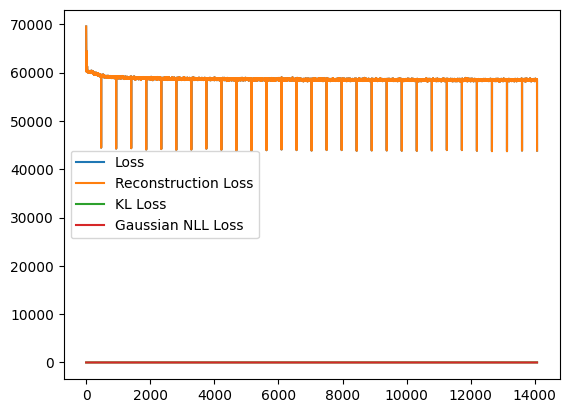

100%|██████████| 30/30 [03:15<00:00,  6.51s/it]


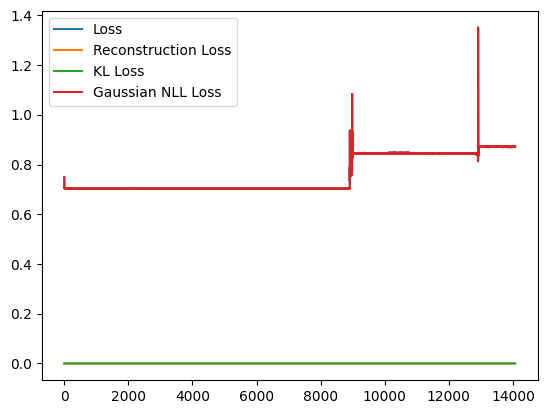

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Using device: {device}")

from utils.train import train_model
from utils.training_params import TrainingParameters
from models.vae import GaussianVariationalAutoencoder

train_params = TrainingParameters(
    learning_rate = 1e-2,
    batch_size = 128,
    num_epochs = 30,
)
hidden_dim = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)
uvae = GaussianVariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)

# Train mean decoder head first
uvae.logvar_decoder.requires_grad = False
train_model(uvae, trainloader, train_params, device, save=True)

uvae.mu_training = False
uvae.logvar_decoder.requires_grad = True
uvae.mu_decoder.requires_grad = False
uvae.encoder.requires_grad = False
train_model(uvae, trainloader, train_params, device, save=True)

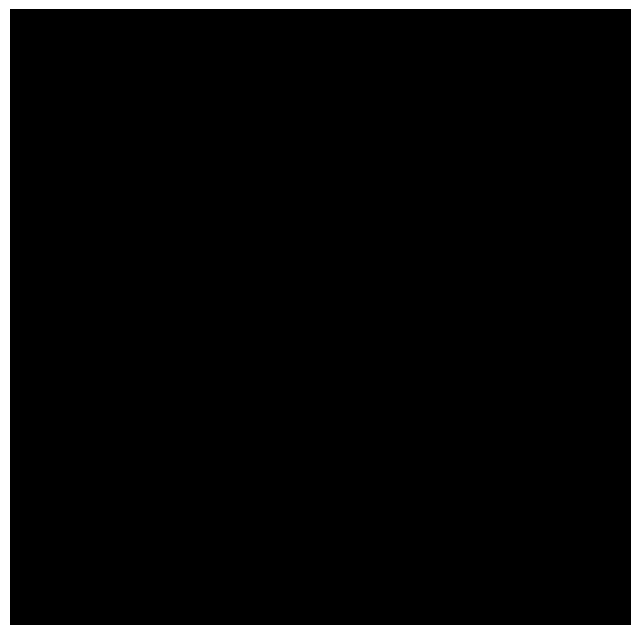

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
model = uvae

n_steps = 32

# Create a grid of points between 0.01 and 0.99
x = torch.linspace(0.01, 0.99, n_steps)
y = torch.linspace(0.01, 0.99, n_steps)

# Create a grid of points
grid_points = torch.zeros(n_steps * n_steps, 2)

# Create meshgrid of points
X, Y = torch.meshgrid(x, y, indexing='ij')

# Convert to standard normal values using inverse CDF (probit function)
from scipy.stats import norm
X = torch.tensor(norm.ppf(X.numpy().astype(np.float32)))
Y = torch.tensor(norm.ppf(Y.numpy().astype(np.float32)))

# Combine into grid points
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1).float().to(device)

# Generate images from the latent points
with torch.no_grad():
    model.eval()
    generated = model.mu_decoder(grid_points)
    # generated = model.logvar_decoder(grid_points)
    generated = generated.reshape(-1, 1, 28, 28)

_, axes = plt.subplots(n_steps, n_steps, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_steps):
    for j in range(n_steps):
        axes[i,j].imshow(generated[i * n_steps + j].cpu().squeeze(), cmap='gray')
        axes[i,j].axis('off')

plt.show()